# Load Imports

In [ ]:
# system 
import sys
import os 
import argparse
sys.path.append("/workspace/")

# Torch 
import torch

# tools 
import numpy as np 

# data loader 
import dataloader

# import model 
import models
import torchinfo
from torchview import draw_graph

# Loss 
import losses

# Visualize 
from visualize import PointCloudInferenceVisualizer

import cv2
import matplotlib.pyplot as plt 
import torchvision.transforms as T
from PIL import Image

# Transform
import transform



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Load Config
1. Select Model 
2. Select Dataset 


In [ ]:
# Create an ArgumentParser object
parser = argparse.ArgumentParser(description="Run camera-LiDAR calibration experiments.")

# General configuration
parser.add_argument('--root', default="/workspace", type=str, help='Root folder path')
parser.add_argument('--project_name', default="camera-lidar", type=str, help='WandB project name')
parser.add_argument('--group_name', default="test_experiment", type=str, help='Experiment group name')
parser.add_argument('--use_sweeps', default=False, action='store_true', help='Enable WandB hyperparameter sweeps')
parser.add_argument('--sweep_id', default=None, type=str, help='WandB sweep ID')
parser.add_argument('--count', default=0, type=int, help='Number of sweep runs to execute')

# Model settings
parser.add_argument('--model', default='calibvit', type=str, choices=['calibvit', 'calibnet'], help='Model type')
parser.add_argument('--version', default='v1', type=str, choices=['v1', 'v2'], help='Model version')
parser.add_argument('--inner_iter', default=1, type=int, help='Number of inner iterations')

# Dataset settings
parser.add_argument('--dataset', default='nuscenes', type=str, choices=['nuscenes', 'kitti'], help='Dataset name')
parser.add_argument('--max_deg', default=10, type=int, choices=range(1, 16), help='Max decalibration rotation (degrees)')
parser.add_argument('--max_tran', default=0.25, type=float, help='Max decalibration translation (meters)')
parser.add_argument('--distribution', default='uniform', type=str, choices=['uniform', 'gaussian', 'inverse_gaussian'], help='Decalibration distribution')

# Mode
parser.add_argument('--mode', default='test', choices=['train', 'val', 'test'], help='Mode of operation')

# Training settings
parser.add_argument('--num_workers', default=4, type=int, help='Number of data loader workers')
parser.add_argument('--batch_size', default=32, type=int, help='Batch size')
parser.add_argument('--epochs', default=10, type=int, help='Number of epochs')
parser.add_argument('--lr', default=1e-4, type=float, help='Learning rate')

# Logging
parser.add_argument('--use_wandb', default=False, action='store_true', help='Log data to WandB')
parser.add_argument('--visualize', default=False, action='store_true', help='Visualize predictions')

# Parse the arguments (without any actual command-line arguments)
args = parser.parse_args(['--root', '/workspace', '--model', 'calibvit', '--version', 'v2', '--mode', 'test', '--max_deg' , '10', '--max_tran', '0.25', '--batch_size', '1'])


In [ ]:
from config import Config
global config
config = Config(args )
import pprint
def get_object_vars(obj):
    """
    Recursively get the attributes of an object and its nested objects as a dictionary.
    """
    if not hasattr(obj, '__dict__'):
        return obj  # Base case: return the object itself if it has no __dict__ attribute

    return {key: get_object_vars(value) if hasattr(value, '__dict__') else value 
            for key, value in obj.__dict__.items()}

pp = pprint.PrettyPrinter(depth=5)
pp.pprint(get_object_vars(config))

{'checkpoint_path': '/workspace/results/calibvit/v4/checkpoint',
 'count': 0,
 'dataset': 'kitti',
 'dataset_config': {'cam_id': 2,
                    'distribution': 'gaussian',
                    'extend_ratio': [2.5, 2.5],
                    'image_size': [320, 512],
                    'mag_randomly': False,
                    'max_deg': 10,
                    'max_depth': 80,
                    'max_intensity': 1,
                    'max_tran': 0.2,
                    'min_depth': 0,
                    'min_intensity': 0,
                    'num_neighbours': 40,
                    'num_workers': 12,
                    'pcd_min_samples': 8192,
                    'pooling_size': 3,
                    'resize_ratio': [1.0, 1.0],
                    'skip_frame': 1,
                    'test_perturb_file': '/workspace/weights/test_decalib/kitti_test_gaussian_10_0.2.csv',
                    'test_sequences': ['00'],
                    'train_sequences': ['01',
         

# Kitti Dataset

In [ ]:
test_loader, test_sampler = dataloader.load_dataset(config=config,recorder=None)

>> Using:/workspace/weights/test_decalib/kitti_test_gaussian_10_0.2.csv


# Print details of Input Data

In [25]:
for i, val in enumerate(test_loader):
    data =val
    if i == 5:
        break

for key,value in data.items():
    if isinstance(value,torch.Tensor):
        shape = value.shape
    else:
        shape = value
    print('{key}: {shape}'.format(key=key,shape=shape))

img: torch.Size([1, 3, 320, 512])
pcd: torch.Size([1, 3, 8192])
pcd_range: torch.Size([1, 8192])
intensity: torch.Size([1, 8192])
density: torch.Size([1, 8192])
depth_img: torch.Size([1, 3, 320, 512])
InTran: torch.Size([1, 3, 3])
ExTran: torch.Size([1, 4, 4])
uncalibed_pcd: torch.Size([1, 3, 8192])
uncalibed_depth_img: torch.Size([1, 3, 320, 512])
igt: torch.Size([1, 4, 4])


# Load Model 

In [26]:
model = models.load_model(config=config.model_config, recorder=None)
model = models.load_checkpoint(config=config.model_config, model=model)
model = model.eval().cpu()

>>> <All keys matched successfully>


In [ ]:
se3 = transform.SE3()

# Get inference 

In [31]:
# Input Data 
input_rgb_img = data['img']
input_depth_img = data['uncalibed_depth_img']

# For Multi Iteration 
pcd_range = data['pcd_range']
intensity = data['intensity']
density = data['density']

# Point cloud 
input_pcd = data['uncalibed_pcd']

# Transformations 
gt_intirnsic = data['InTran'][0]
gt_extrinsic = data['igt']

pred_tf = torch.eye(4).repeat(1,1,1)

depth_generator = transform.DepthImgGenerator(input_rgb_img.shape[-2:], gt_intirnsic, pcd_range, intensity, density, config.dataset_config.pooling_size)


# Iter 1 

In [32]:
rot, trans = model(input_rgb_img, input_depth_img)
iter_tf_1 = se3.exp(torch.cat([rot,trans],dim=1))
pred_tf = pred_tf.bmm(iter_tf_1)

In [37]:
def compute_error(pred_tf, gt_tf):
    error = pred_tf.bmm(gt_tf)

    # Get ground truth and predicted rotation and translation vectors
    gt_rot, gt_trans = eval.get_rotation_translation_from_transform(gt_tf.cpu())
    pred_rot, pred_trans = eval.get_rotation_translation_from_transform(pred_tf.cpu())

    # Convert rotation matrices to Euler angles
    gt_euler_angles = eval.rotation_matrix_to_euler(gt_rot)
    pred_euler_angles = eval.rotation_matrix_to_euler(pred_rot)

    # Calculate errors in rotation and translation
    
    err_rot, err_trans = eval.get_rotation_translation_from_transform(error.cpu())
    err_euler_angles = eval.rotation_matrix_to_euler(err_rot)

    return err_euler_angles.tolist(), err_trans.tolist(), gt_euler_angles.tolist(), gt_trans.tolist()


# Compute Error 

In [31]:
E_rot, E_trans , GT_rot, GT_trans=  compute_error(iter_tf_1, gt_extrinsic)   #eval.get_stats()

print("Euler Angles Input Error --> Pred  Rx, Ry, Rz : ", np.round(GT_rot,4), "-->", np.round(E_rot,4) , " Mean -->", np.round(np.mean(np.abs(E_rot)),4)  )
print("Translation InputError --> Tx, Ty, Tz : ", np.round(GT_trans,4) , "-->",  np.round(E_trans,4),  " Mean -->", np.round(np.mean(np.abs(E_trans)),4) )

Euler Angles Input Error --> Pred  Rx, Ry, Rz :  [[ 7.8357  3.9615 -4.5196]] --> [[ 3.0954  0.6642 -0.8391]]  Mean --> 1.5329
Translation InputError --> Tx, Ty, Tz :  [[-0.1354  0.0211  0.1741]] --> [[-0.1034  0.0794  0.1223]]  Mean --> 0.1017


# Visualize Inference One Shot 

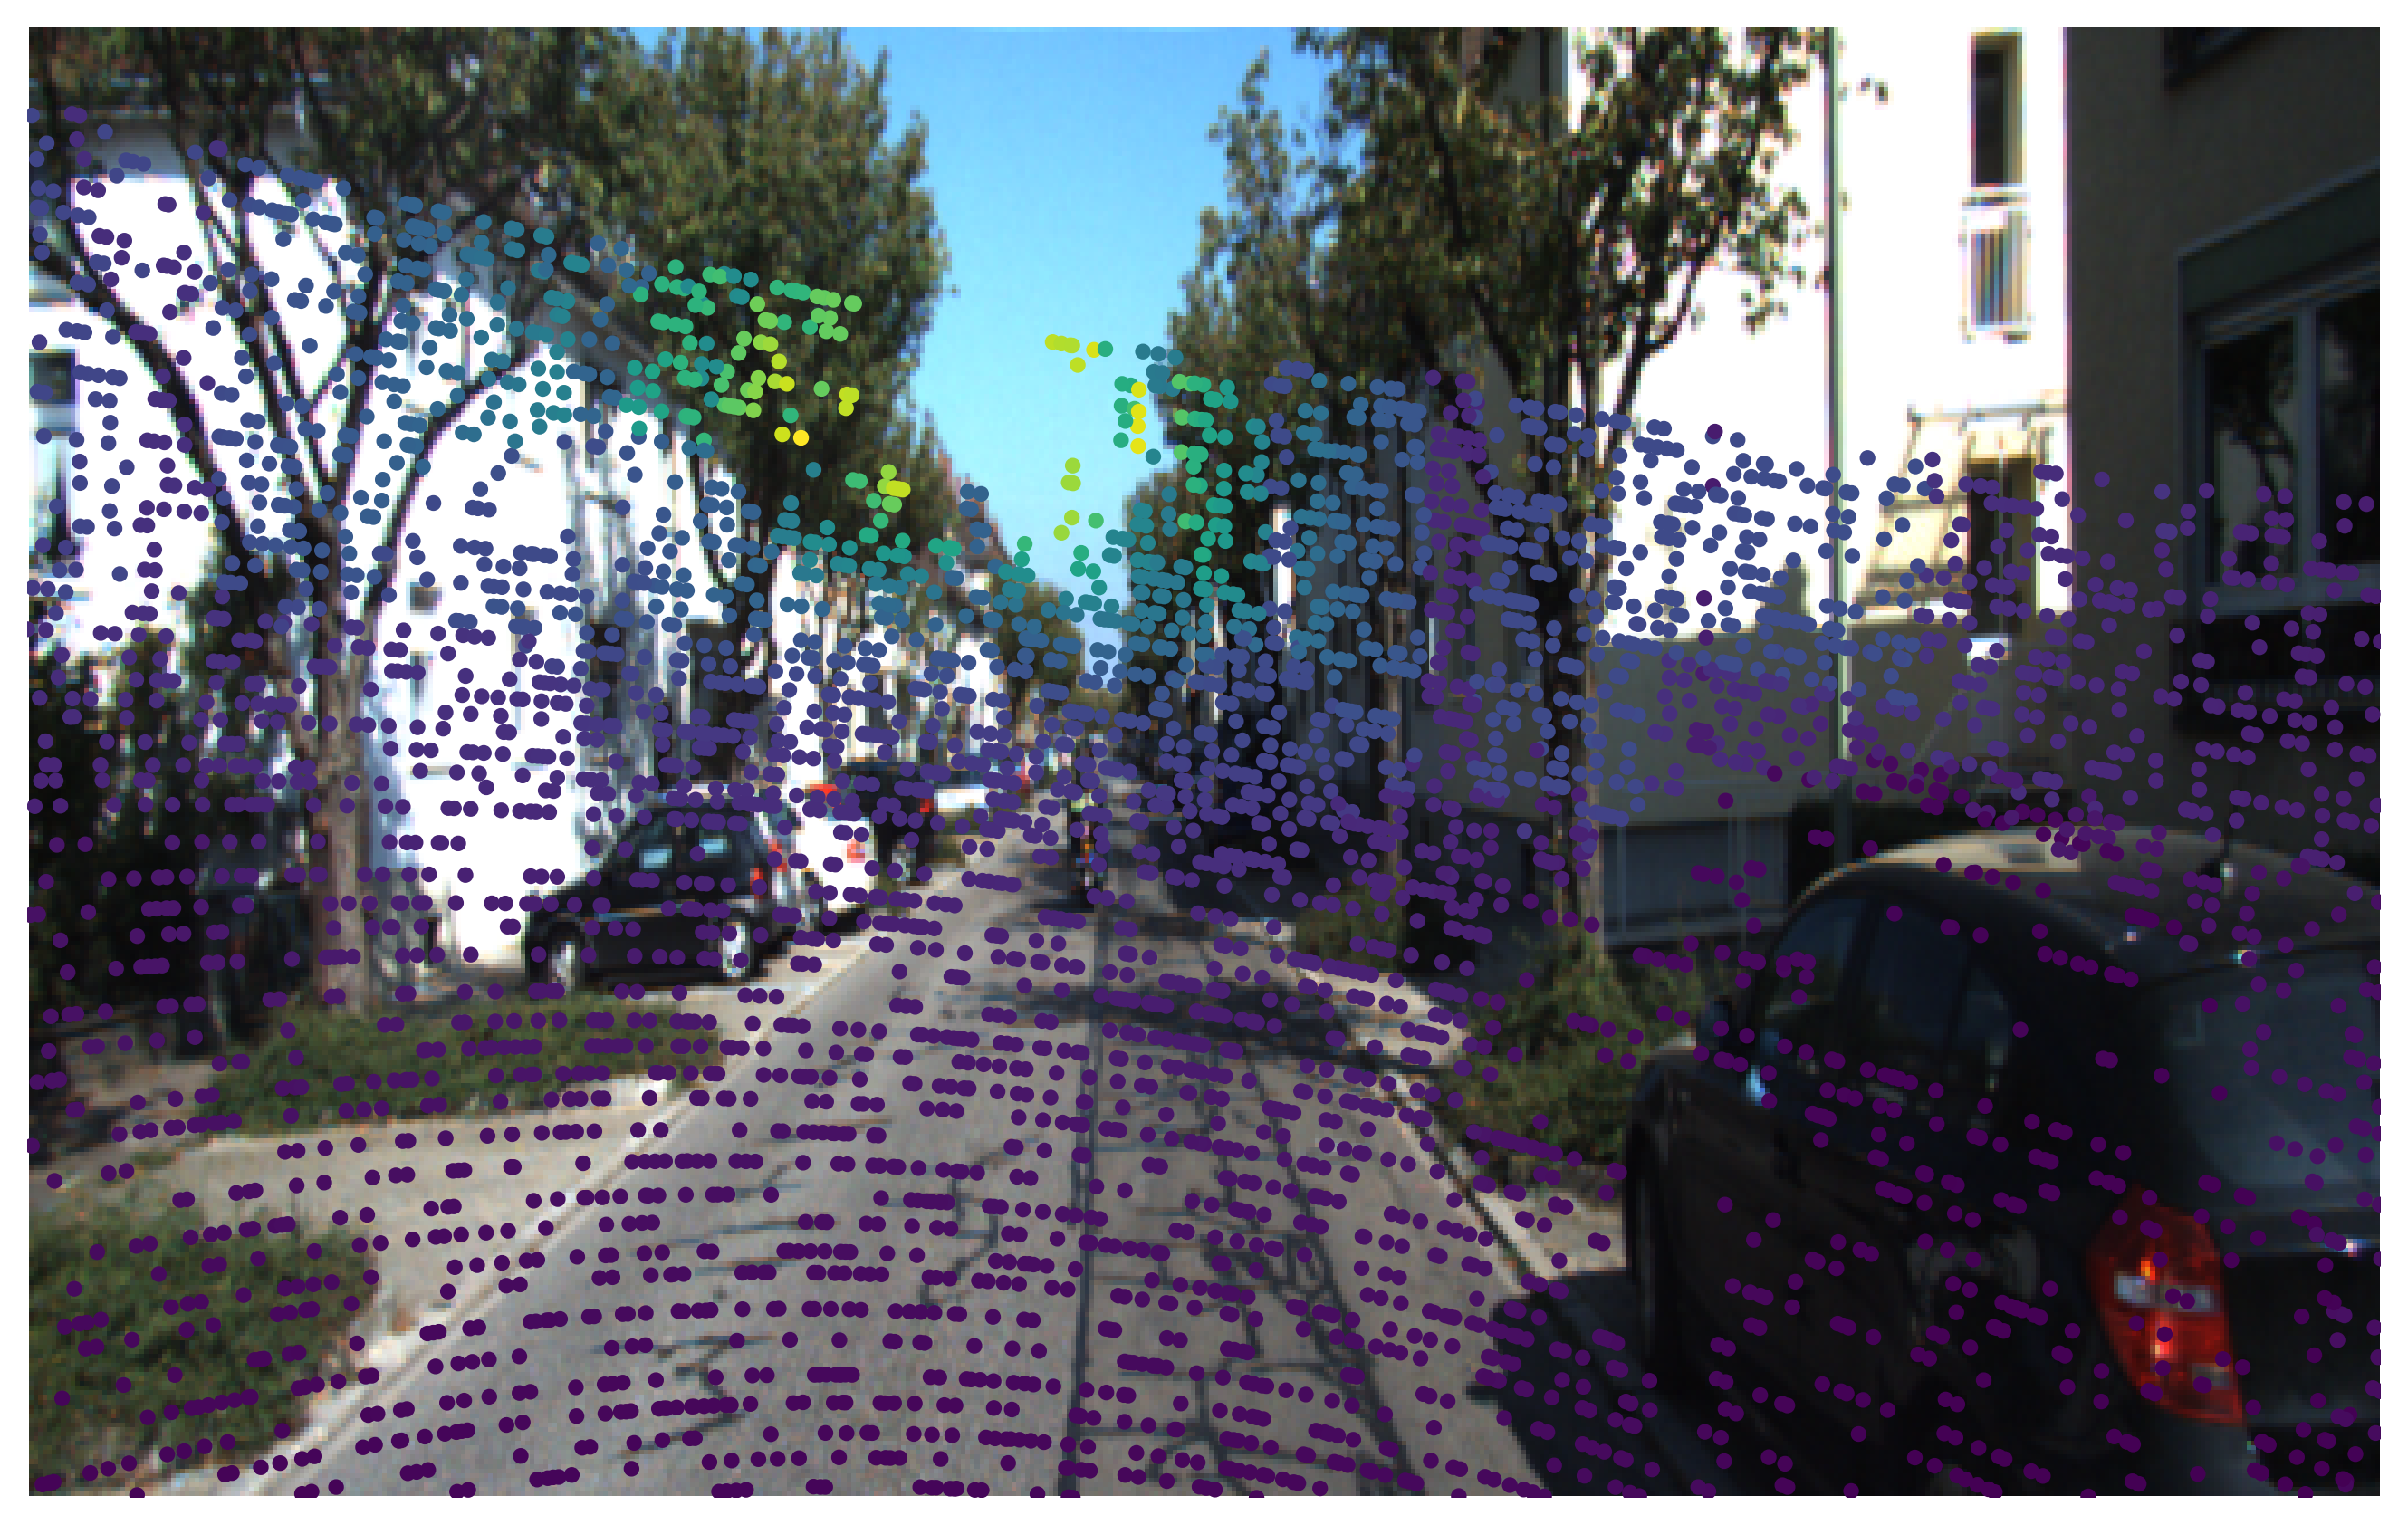

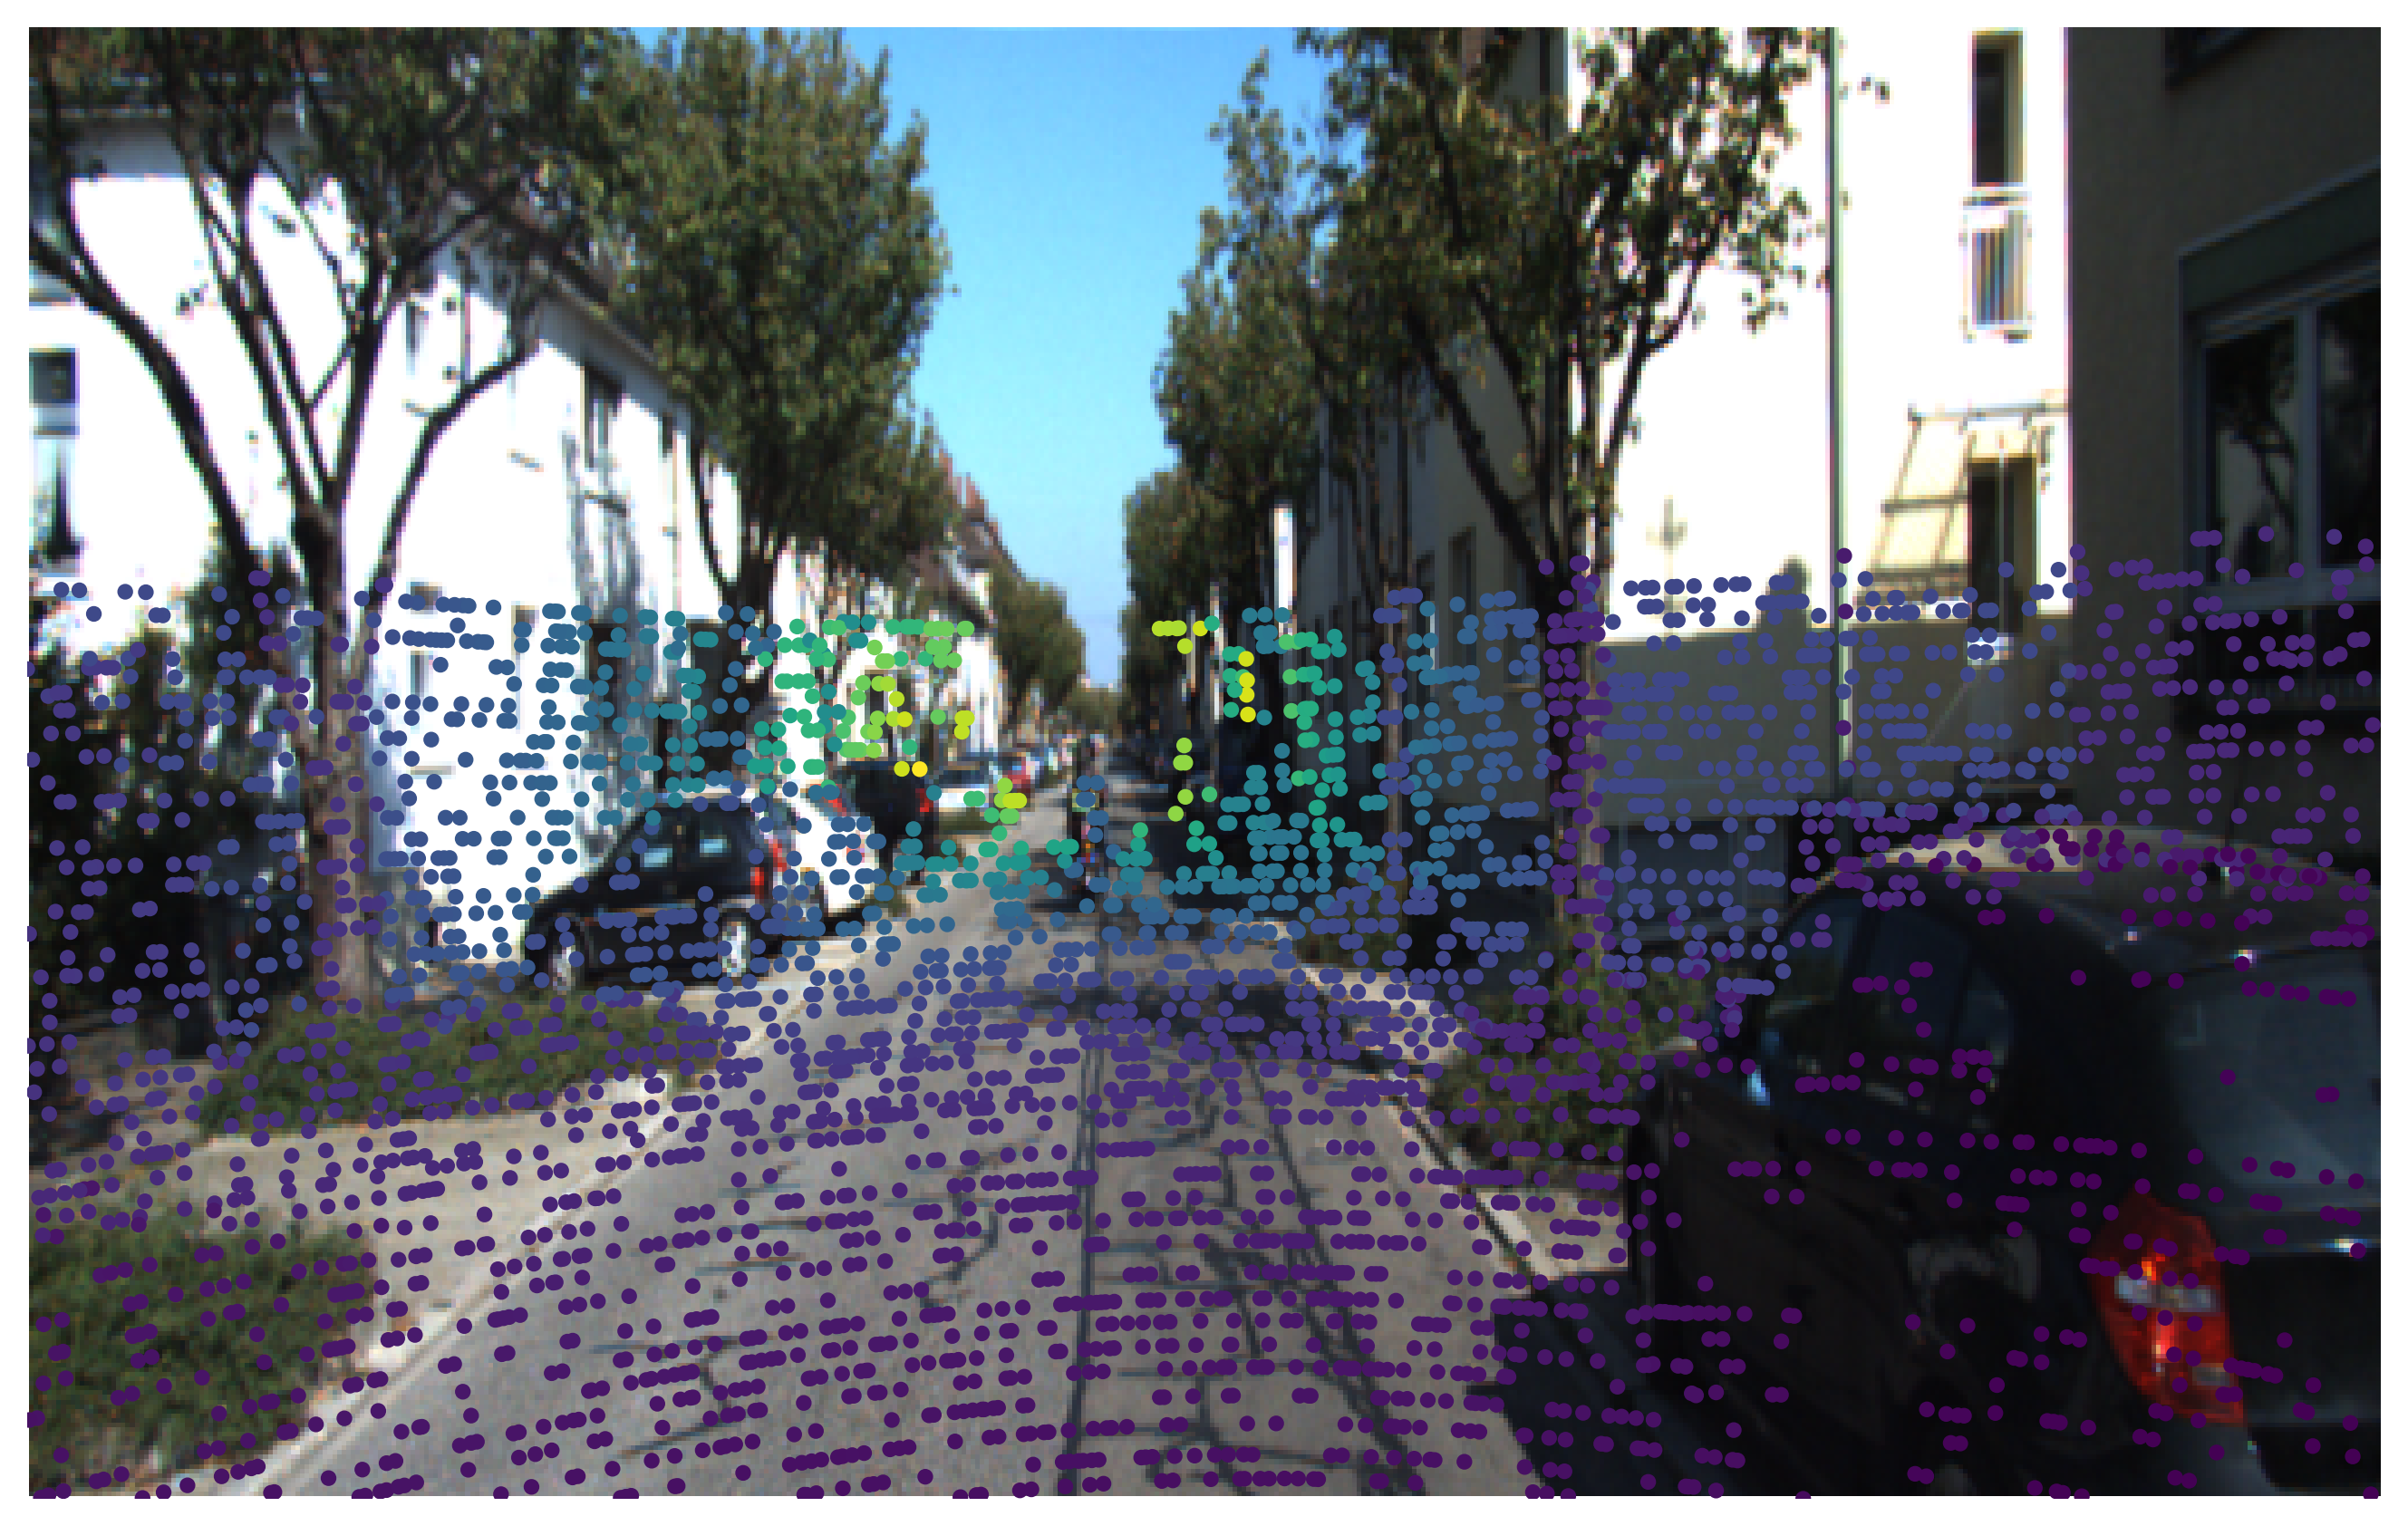

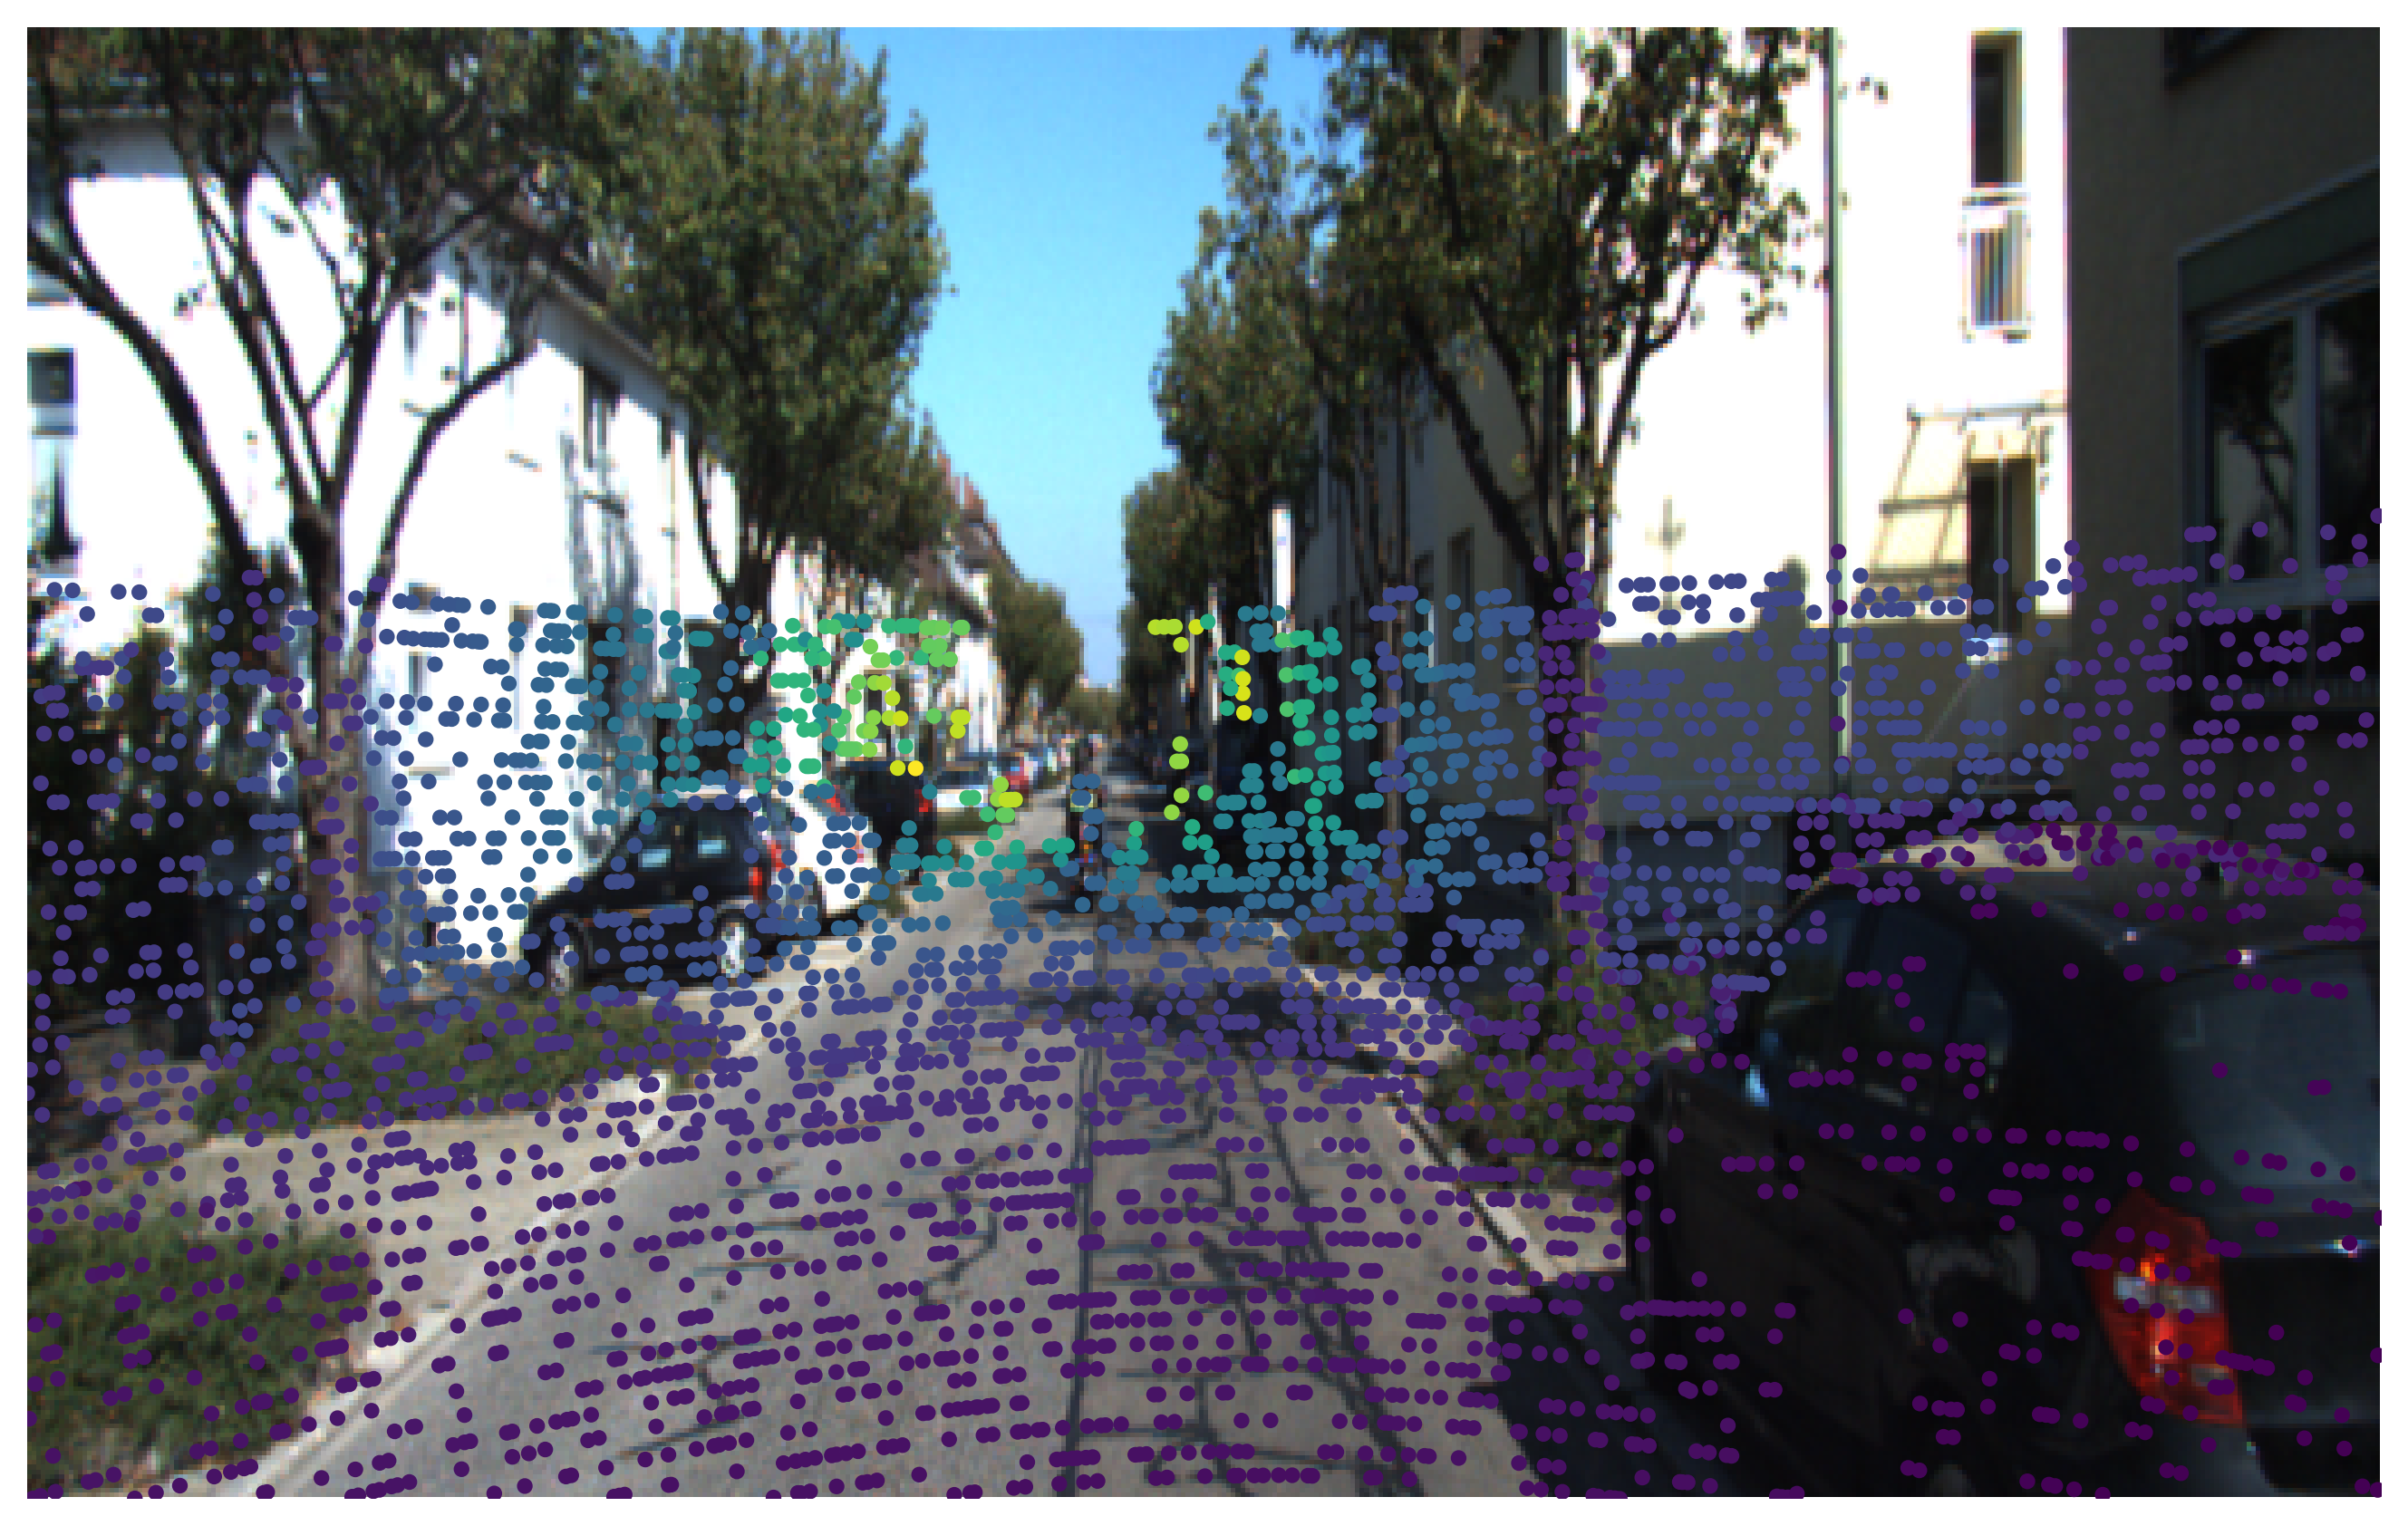

In [42]:
viz = PointCloudInferenceVisualizer()
viz.plot_inference(data, pred_tf,0, all_points=False, show=True)

## Transfrom Point Cloud with predicted TF

In [33]:
depth_image_iter_1, _ = depth_generator(pred_tf, input_pcd)   

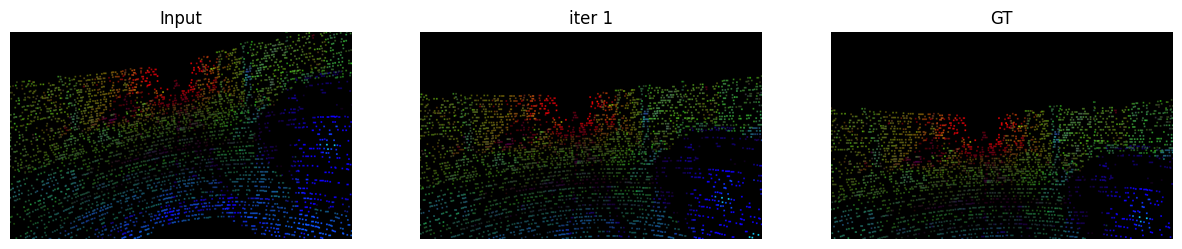

In [34]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(15,5))
ax0.imshow(np.clip(input_depth_img.squeeze(0).permute(1,2,0).numpy(),0,1))
ax0.set_title('Input')
ax1.imshow(np.clip(depth_image_iter_1.squeeze(0).permute(1,2,0).numpy(),0,1))
ax1.set_title('iter 1')
ax2.imshow(np.clip(data['depth_img'].squeeze(0).permute(1,2,0).numpy(),0,1))
ax2.set_title('GT')
ax1.axis("off")
ax0.axis("off")
ax2.axis("off")
plt.show()

## Iter 2 

In [35]:
rot, trans = model(input_rgb_img, depth_image_iter_1)
iter_tf_2 = se3.exp(torch.cat([rot,trans],dim=1))
pred_tf = pred_tf.bmm(iter_tf_2)

In [36]:
E_rot, E_trans , GT_rot, GT_trans=  compute_error(pred_tf, gt_extrinsic)   #eval.get_stats()
print("Euler Angles Input Error --> Pred  Rx, Ry, Rz : ", np.round(GT_rot,4), "-->", np.round(E_rot,4) , " Mean -->", np.round(np.mean(np.abs(E_rot)),4)  )
print("Translation InputError --> Tx, Ty, Tz : ", np.round(GT_trans,4) , "-->",  np.round(E_trans,4), " Mean -->", np.round(np.mean(E_trans),4) )

Euler Angles Input Error --> Pred  Rx, Ry, Rz :  [[ 7.8357  3.9615 -4.5196]] --> [[ 0.0575 -0.8507 -0.0435]]  Mean --> 0.3172
Translation InputError --> Tx, Ty, Tz :  [[-0.1354  0.0211  0.1741]] --> [[ 0.0227 -0.0052  0.0138]]  Mean --> 0.0104


# iter 3

In [39]:
depth_image_iter_2, _ = depth_generator(pred_tf, input_pcd)   

In [40]:
rot, trans = model(input_rgb_img, depth_image_iter_2)
iter_tf_3 = se3.exp(torch.cat([rot,trans],dim=1))
pred_tf = pred_tf.bmm(iter_tf_3)

In [41]:
E_rot, E_trans , GT_rot, GT_trans=  compute_error(pred_tf, gt_extrinsic)   #eval.get_stats()
print("Euler Angles Input Error --> Pred  Rx, Ry, Rz : ", np.round(GT_rot,4), "-->", np.round(E_rot,4) , " Mean -->", np.round(np.mean(np.abs(E_rot)),4))
print("Translation InputError --> Tx, Ty, Tz : ", np.round(GT_trans,4) , "-->",  np.round(E_trans,4) , " Mean -->", np.round(np.mean(np.abs(E_trans)),4))


Euler Angles Input Error --> Pred  Rx, Ry, Rz :  [[ 7.8357  3.9615 -4.5196]] --> [[-0.025  -0.7886  0.0992]]  Mean --> 0.3043
Translation InputError --> Tx, Ty, Tz :  [[-0.1354  0.0211  0.1741]] --> [[ 0.0139 -0.0249 -0.0369]]  Mean --> 0.0252
